### 3022 Introduction to Data Science - Final Project - Fall 2019
### Predicting the Age of Abalone by Body Measurements
#### Sabine Hollatz

### The Problem
Abalone are marine snails with a single shell that live on rocks along the coastlines around the world. Their meat is considered to be a delicacy and their shells are used for producing jewelery and other decorative objects. The global population has declined by more than 50% according to the FAO. In California is the harvest of natural populations strongly restricted. Demands are met by farming abalone. The age can only be determined from the inside of the shell, which is time-consuming and can insure the animal. Predicting the age range from body measurments that can be assessed from the outside would improve the research as well as farming evaluations.

### The Data
The dataset is collected by the Sea Fisheries Division in Tasmania 1994 and publicly available at kaggle.com: <br>
https://www.kaggle.com/hurshd0/abalone-uci#abalone_original.csv

8 body charateristics of 4177 abalone are taken, including sex (male, female, infant), length, diameter, height, number of rings, and weights of different body parts. The units are in millimiters or grams. The age is traditionally determined by the number of rings plus 1.5.

### Proposed Types of Analysis
The first step in the exploratory data analysis will be to check for missing values and fill them in. Missing values in the numerical variables will be replaced by the variable mean and missing data in the categorical variable will be replaced by the mode. However, missing values in the number of rings cannot be filled in by measures of central tendencies since they are the values that need to be predicted in the future and will be filled in with "nan". The next step will be the visualization of the 7 numerical variables seperated by sex. Box plots will provide a first insight of the variable distributions and can indicate possible outliers. 
Correlations between body measurements are expected and will be determind by calculating the correlation coefficients for each possible variable pair. According to a study by the Department of Biology, California Fish and Game, the populations of red abalone in California have usually more female than male individuen. This trend will be compared with the Tasmanian population by calculating the X^2. Furthermore, female red abalone in California mature at a smaller size than males. If this difference is also true for the Tasmanian abalone, different classifiers will be trained to predict the sex based on physical characteristics.
To predict the age range of abalone linear and polynomial regression models will be calculated and evaluated. For that method, the continous variables need to be normalized. If time allows and data can be found, further data will be add for different regions, species and environmental conditions.

Difficulties are anticipated in the limitations of the dataset due to the small number of attributes. More data and different, related data could improve the flexibility in prediction methods.

### EDA

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
df_abalone = pd.read_csv('abalone_original.csv')
df_abalone.head()                       

,sex,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,rings
0,M,91,73,19,102.8,44.9,20.2,30.0,15
1,M,70,53,18,45.1,19.9,9.7,14.0,7
2,F,106,84,27,135.4,51.3,28.3,42.0,9
3,M,88,73,25,103.2,43.1,22.8,31.0,10
4,I,66,51,16,41.0,17.9,7.9,11.0,7


#### Check for Missing Values

In [3]:
df_abalone.isnull().count()

sex               4177
length            4177
diameter          4177
height            4177
whole-weight      4177
shucked-weight    4177
viscera-weight    4177
shell-weight      4177
rings             4177
dtype: int64

There are no missing values in the dataset.

#### Rename Variables

In [4]:
# Some Python libraries have difficulty reading a variable name with a hyphen, so they need to be renamed.
old_names = ['whole-weight', 'shucked-weight', 'viscera-weight', 'shell-weight']
new_names = ['whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']
new_all = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']

df_abalone[new_names] = df_abalone[old_names]
df_abalone = df_abalone.drop(old_names, axis=1)
df_abalone = df_abalone[new_all]
df_abalone.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,91,73,19,102.8,44.9,20.2,30.0,15
1,M,70,53,18,45.1,19.9,9.7,14.0,7
2,F,106,84,27,135.4,51.3,28.3,42.0,9
3,M,88,73,25,103.2,43.1,22.8,31.0,10
4,I,66,51,16,41.0,17.9,7.9,11.0,7


#### Visualization of Attribute Distributions 
Box plots will provide a first insight of the variable distributions and can indicate possible outliers. 
Since there exist one categorical variable "sex", that has the 3 different values "M" for male, "F" for female, and "I" for infant, the visualization of the numerical features is separated by sex.

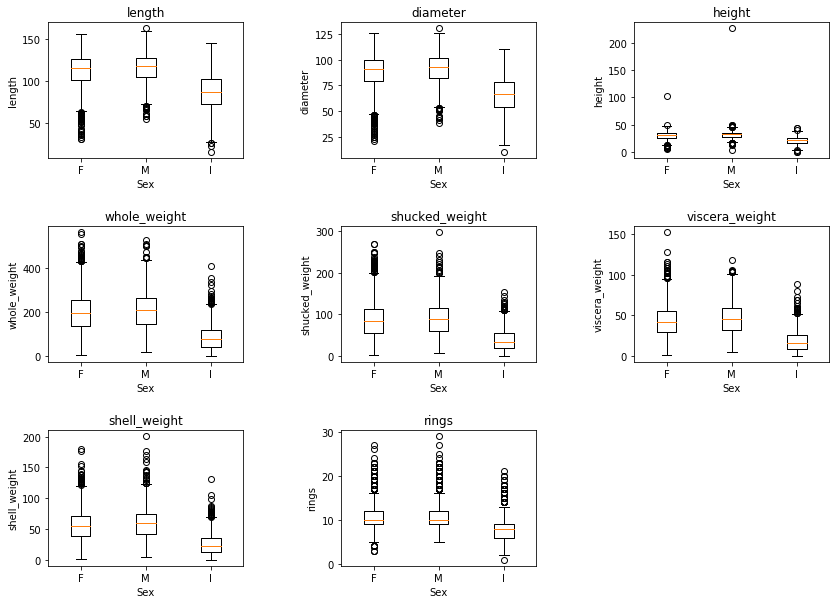

In [5]:
sex = ['M', 'F', 'I']
columns = ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,10))


for i in range(len(columns)):
    attributes = []
    for j in range(len(sex)):
        attributes.append(df_abalone.loc[df_abalone.sex==sex[j], columns[i]].values)
    if i < 3:
        ax[0,i].boxplot([attributes[0], attributes[1], attributes[2]], labels=['F', 'M', 'I'])
        ax[0,i].set_title(columns[i])
        ax[0,i].set_xlabel('Sex')
        ax[0,i].set_ylabel(columns[i])
    elif i < 6:
        ax[1,i-3].boxplot([attributes[0], attributes[1], attributes[2]], labels=['F', 'M', 'I'])
        ax[1,i-3].set_title(columns[i])
        ax[1,i-3].set_xlabel('Sex')
        ax[1,i-3].set_ylabel(columns[i])
    else:
        ax[2,i-6].boxplot([attributes[0], attributes[1], attributes[2]], labels=['F', 'M', 'I'])
        ax[2,i-6].set_title(columns[i])
        ax[2,i-6].set_xlabel('Sex')
        ax[2,i-6].set_ylabel(columns[i])

#     print(attributes[0])
ax[2,2].remove()
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

The features appear to be normally distributed, where some attributes are less skewed than others. 
The attribute, that is most skewed seems to be the number of rings. The distribution for both females and males are right skewed, but infants are left skewed. Most features show outliers only to one side except 'height'. The next step is to identify outliers.

#### Check Datatypes
To ensure that future calculations run smoothly, the datatypes are checked and eventually adjusted.

In [6]:
df_abalone.dtypes

sex                object
length              int64
diameter            int64
height              int64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings               int64
dtype: object

In [7]:
# change length, diameter, height to float64 
# change object to category
df_abalone['sex'] = df_abalone['sex'].astype('category')
df_abalone[['length', 'diameter', 'height']] = df_abalone[['length', 'diameter', 'height']].astype('float64')
df_abalone.dtypes

sex               category
length             float64
diameter           float64
height             float64
whole_weight       float64
shucked_weight     float64
viscera_weight     float64
shell_weight       float64
rings                int64
dtype: object

#### Outliers Detection

In [8]:
def outlierCheck(df, attr):
    outlier_indices = []
    outlier_values = []
    inlier_indices = []
    q1 = df[attr].quantile(.25)
    q3 = df[attr].quantile(.75)
    iqr = q3 - q1
    
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    for index, row in df.iterrows():
        if row[attr] > upper_bound:
            outlier_indices.append(index)
            outlier_values.append(row[attr])
        elif row[attr] < lower_bound:
            outlier_indices.append(index)
            outlier_values.append(row[attr])
        else:
            inlier_indices.append(index)
    return inlier_indices, outlier_indices, outlier_values
    
females = df_abalone[df_abalone.sex == "F"]
males = df_abalone[df_abalone.sex == "M"]
infants = df_abalone[df_abalone.sex == "I"]

# count number of outliers per sex
outliers_female = []
outliers_male = []
outliers_infant = []
for feature_f in females.columns:
    if feature_f == 'sex':
        continue
    inlier_f, outlier_f, _ = outlierCheck(females, feature_f)
    if feature_f != 'rings':
        outliers_female = outliers_female + outlier_f
    print("In females feature {} are {} outliers".format(feature_f, len(outlier_f)))
print("")

for feature_m in males.columns:
    if feature_m == 'sex':
        continue
    inlier_m, outlier_m, _ = outlierCheck(males, feature_m)
    if feature_m != 'rings':
        outliers_male = outliers_male + outlier_m
    print("In males feature {} are {} outliers".format(feature_m, len(outlier_m)))
print("")

for feature_i in infants.columns:
    if feature_i == 'sex':
        continue
    inlier_i, outlier_i, _ = outlierCheck(infants, feature_i)
    if feature_i != 'rings':
        outliers_infant = outliers_infant + outlier_i
    print("In infants feature {} are {} outliers".format(feature_i, len(outlier_i)))

outliers = set(outliers_female + outliers_male + outliers_infant)
print("")
print("A total of {} outliers are in all features other than 'sex' and 'rings' detected".format(len(outliers)))

In females feature length are 15 outliers
In females feature diameter are 16 outliers
In females feature height are 23 outliers
In females feature whole_weight are 11 outliers
In females feature shucked_weight are 14 outliers
In females feature viscera_weight are 8 outliers
In females feature shell_weight are 19 outliers
In females feature rings are 92 outliers

In males feature length are 41 outliers
In males feature diameter are 43 outliers
In males feature height are 15 outliers
In males feature whole_weight are 29 outliers
In males feature shucked_weight are 30 outliers
In males feature viscera_weight are 22 outliers
In males feature shell_weight are 25 outliers
In males feature rings are 94 outliers

In infants feature length are 4 outliers
In infants feature diameter are 1 outliers
In infants feature height are 7 outliers
In infants feature whole_weight are 21 outliers
In infants feature shucked_weight are 20 outliers
In infants feature viscera_weight are 20 outliers
In infants f

The feature rings is the target variable for the regression analysis. Therefore, the outliers will not be removed at this point in time. The outliers in the other numeric categories are going to be dropped from the dataset in the next step.

In [9]:
# drop 204 outliers
abalone_cleaned = df_abalone.drop(outliers)
abalone_cleaned.count()

sex               3973
length            3973
diameter          3973
height            3973
whole_weight      3973
shucked_weight    3973
viscera_weight    3973
shell_weight      3973
rings             3973
dtype: int64

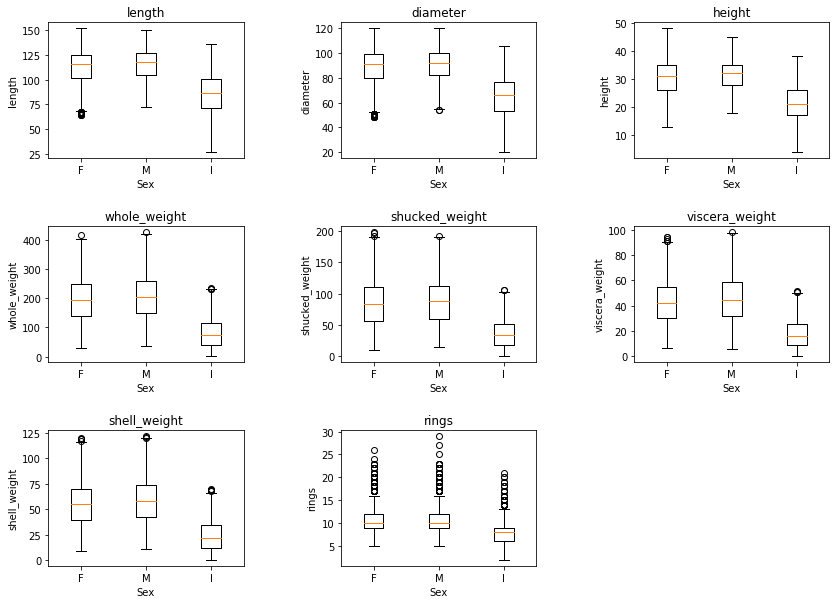

In [10]:
fig1, ax1 = plt.subplots(nrows=3, ncols=3, figsize=(14,10))


for i in range(len(columns)):
    atts = []
    for j in range(len(sex)):
        atts.append(abalone_cleaned.loc[abalone_cleaned.sex==sex[j], columns[i]].values)
    if i < 3:
        ax1[0,i].boxplot([atts[0], atts[1], atts[2]], labels=['F', 'M', 'I'])
        ax1[0,i].set_title(columns[i])
        ax1[0,i].set_xlabel('Sex')
        ax1[0,i].set_ylabel(columns[i])
    elif i < 6:
        ax1[1,i-3].boxplot([atts[0], atts[1], atts[2]], labels=['F', 'M', 'I'])
        ax1[1,i-3].set_title(columns[i])
        ax1[1,i-3].set_xlabel('Sex')
        ax1[1,i-3].set_ylabel(columns[i])
    else:
        ax1[2,i-6].boxplot([atts[0], atts[1], atts[2]], labels=['F', 'M', 'I'])
        ax1[2,i-6].set_title(columns[i])
        ax1[2,i-6].set_xlabel('Sex')
        ax1[2,i-6].set_ylabel(columns[i])

#     print(attributes[0])
ax1[2,2].remove()
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

#### Normalizing the Data

These boxplots provide a first insight in each distribution and potential outliers. However, to compare the difference in measurements between male, femal and infants, the data needs to be scaled.

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
df_abalone_scaled = abalone_cleaned

for attr in columns:
    df_abalone_scaled[attr] = min_max_scaler.fit_transform(abalone_cleaned[attr].values.reshape(-1,1))
df_abalone_scaled.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.512,0.53,0.340909,0.236574,0.223350,0.204476,0.241123,0.481481
1,M,0.344,0.33,0.318182,0.100071,0.096447,0.097660,0.109001,0.185185
2,F,0.632,0.64,0.522727,0.313698,0.255838,0.286877,0.340215,0.259259
3,M,0.488,0.53,0.477273,0.237521,0.214213,0.230926,0.249381,0.296296
4,I,0.312,0.31,0.272727,0.090371,0.086294,0.079349,0.084228,0.185185


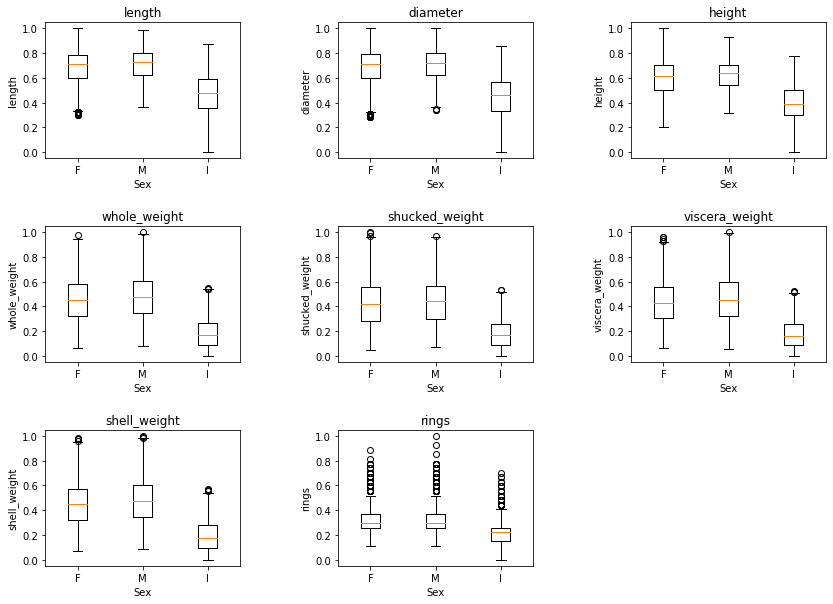

In [12]:
fig2, ax2 = plt.subplots(nrows=3, ncols=3, figsize=(14,10))

for i in range(len(columns)):
    attributes = []
    for j in range(len(sex)):
        attributes.append(df_abalone_scaled.loc[df_abalone_scaled.sex==sex[j], columns[i]].values)
    if i < 3:
        ax2[0,i].boxplot([attributes[0], attributes[1], attributes[2]], labels=['F', 'M', 'I'])
        ax2[0,i].set_title(columns[i])
        ax2[0,i].set_xlabel('Sex')
        ax2[0,i].set_ylabel(columns[i])
    elif i < 6:
        ax2[1,i-3].boxplot([attributes[0], attributes[1], attributes[2]], labels=['F', 'M', 'I'])
        ax2[1,i-3].set_title(columns[i])
        ax2[1,i-3].set_xlabel('Sex')
        ax2[1,i-3].set_ylabel(columns[i])
    else:
        ax2[2,i-6].boxplot([attributes[0], attributes[1], attributes[2]], labels=['F', 'M', 'I'])
        ax2[2,i-6].set_title(columns[i])
        ax2[2,i-6].set_xlabel('Sex')
        ax2[2,i-6].set_ylabel(columns[i])

#     print(attributes[0])
ax2[2,2].remove()
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

Based on this visualization, the infants can be clearly seperated from the adult abalone. Tasmanian male abalone seem to have slightly heavier body parts and dimensions even though the differences are not as obvious and need further confirmation in numbers. Height has the smallest range. In general, the variables appear to be slightly skewed, but relatively normal. The variable 'rings' is the most skewed: there are more younger femal and male abalone and older infant abalone. The medians seem to be closer together than in any of the other variables. This impression should be confirmed with histograms that include the mean and the median.

### Correlation Analysis

A scatterplot matrix can help to identify potential associations.

In [13]:
# find pairwise correlation of all numeric features using Pearson's standard correlation coefficient.
df_abalone_scaled.corr()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
length,1.000000,0.985398,0.894835,0.933354,0.906876,0.905146,0.910641,0.533668
diameter,0.985398,1.000000,0.901739,0.933354,0.901485,0.901457,0.919050,0.553234
height,0.894835,0.901739,1.000000,0.890126,0.837978,0.867118,0.896245,0.590754
whole_weight,0.933354,0.933354,0.890126,1.000000,0.968817,0.964989,0.958519,0.523213
shucked_weight,0.906876,0.901485,0.837978,0.968817,1.000000,0.927806,0.888075,0.401560
viscera_weight,0.905146,0.901457,0.867118,0.964989,0.927806,1.000000,0.913287,0.486724
shell_weight,0.910641,0.919050,0.896245,0.958519,0.888075,0.913287,1.000000,0.610961
rings,0.533668,0.553234,0.590754,0.523213,0.401560,0.486724,0.610961,1.000000


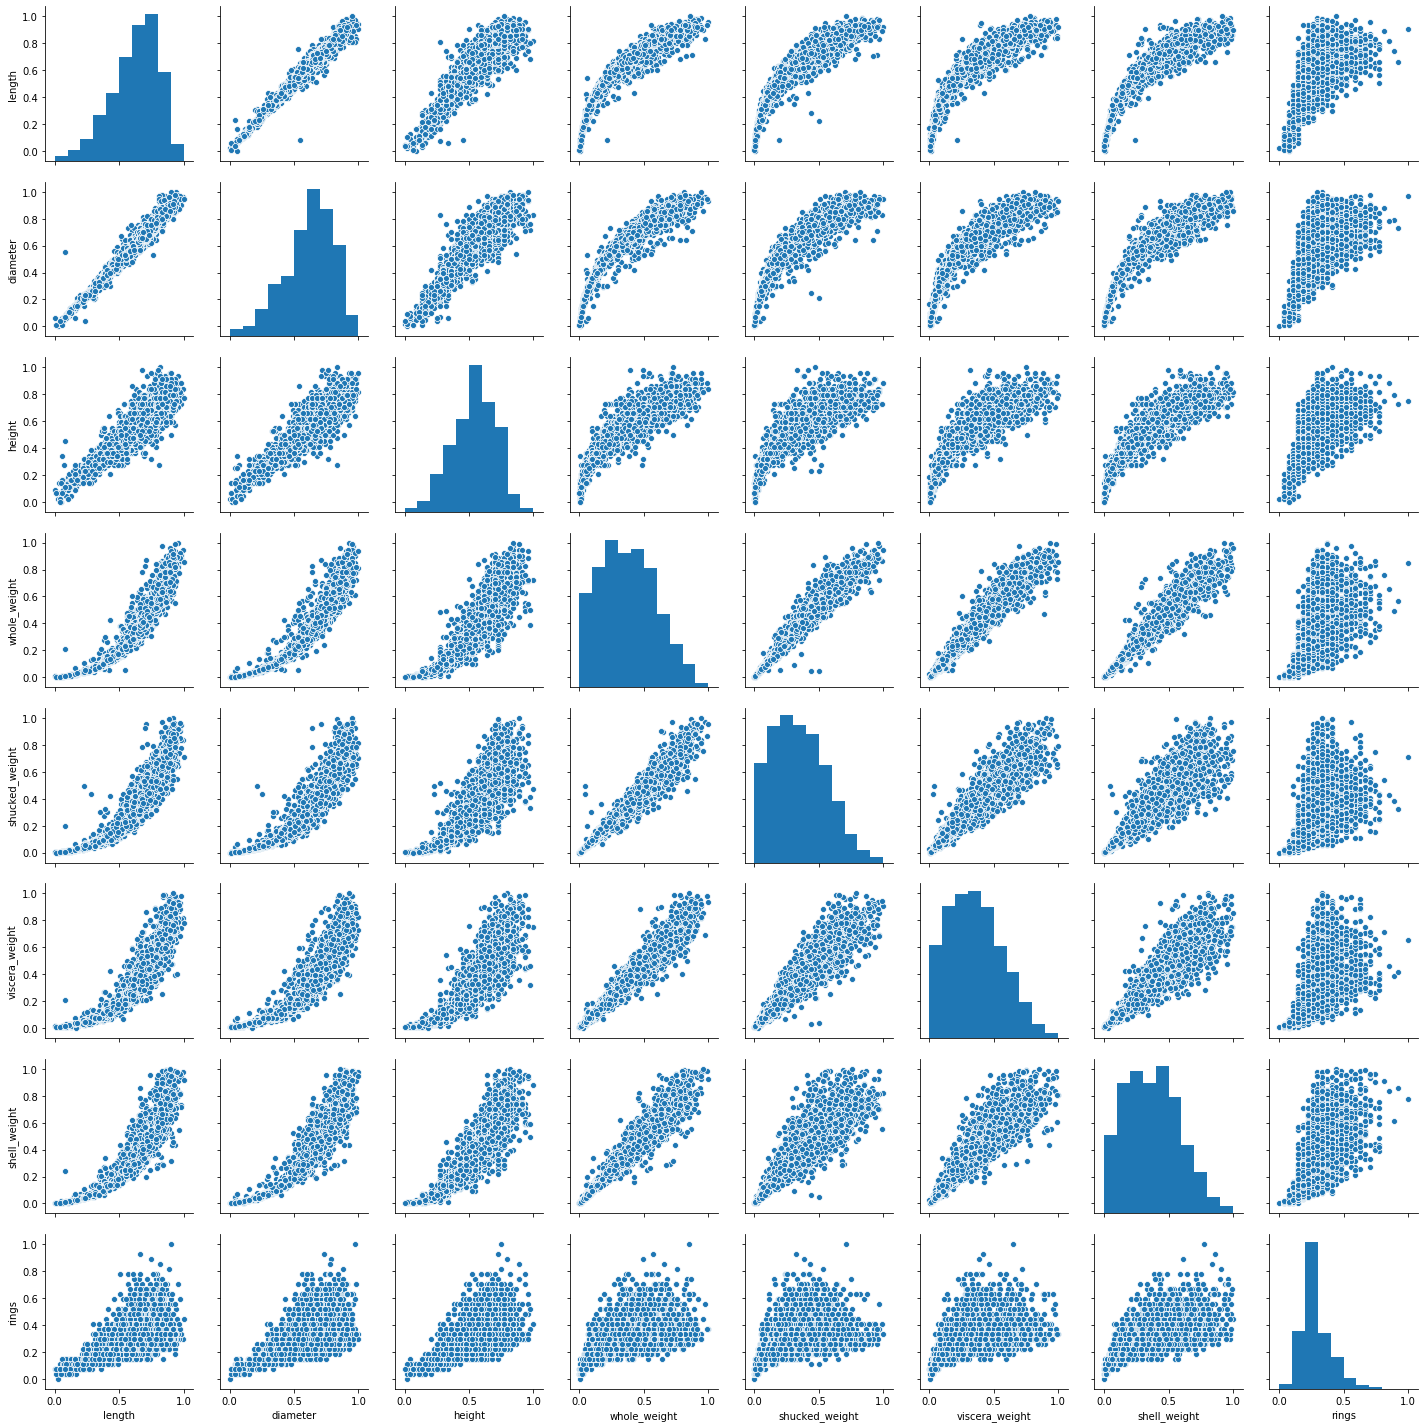

In [14]:
sns.pairplot(df_abalone_scaled);

As expected, there seem to be positive linear and polynomial correlations between attributes. 

In [15]:
# find pairwise correlation of all numeric features using Pearson's standard correlation coefficient.
df_abalone_scaled.corr()["rings"]

length            0.533668
diameter          0.553234
height            0.590754
whole_weight      0.523213
shucked_weight    0.401560
viscera_weight    0.486724
shell_weight      0.610961
rings             1.000000
Name: rings, dtype: float64

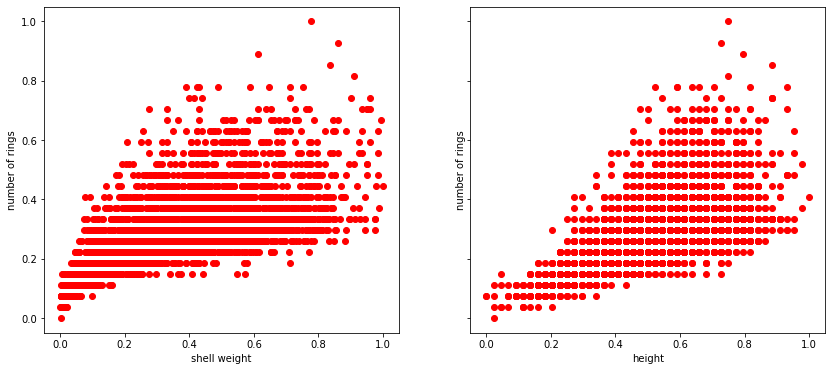

In [16]:
# plotting the factors with the strongest correlation factors - shell-weight, height - with rings
fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=True)
ax3[0].plot(df_abalone_scaled['shell_weight'], df_abalone_scaled.rings, 'ro')
ax3[0].set_xlabel('shell weight')
ax3[0].set_ylabel('number of rings')
ax3[1].plot(df_abalone_scaled['height'], df_abalone_scaled.rings, 'ro')
ax3[1].set_xlabel('height')
ax3[1].set_ylabel('number of rings');

### Simple Linear Regression Model

#### Fitting the data

In [17]:
model_shellWeight = smf.ols(formula='rings~shell_weight', data=df_abalone_scaled).fit()
model_shellWeight.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rings   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     2365.
Date:                Thu, 12 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:45:13   Log-Likelihood:                 3831.9
No. Observations:                3973   AIC:                            -7660.
Df Residuals:                    3971   BIC:                            -7647.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1635      0.003     54.015      0.000       0.158       0.169
shell_weight     0.3412      0.007     48.632      0.000       0.327       0.355
==============================================================================
Omnibus:                     1191.901   Durbin-Watson:                   0.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3612.816
Skew:                           1.544   Prob(JB):                         0.00
Kurtosis:                       6.505   Cond. No.                         5.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
model_height = smf.ols(formula='rings~height', data=df_abalone_scaled).fit()
model_height.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rings   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     2129.
Date:                Thu, 12 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:45:13   Log-Likelihood:                 3756.4
No. Observations:                3973   AIC:                            -7509.
Df Residuals:                    3971   BIC:                            -7496.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0676      0.005     13.274      0.000       0.058       0.078
height         0.4168      0.009     46.138      0.000       0.399       0.435
==============================================================================
Omnibus:                     1247.989   Durbin-Watson:                   1.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3978.763
Skew:                           1.599   Prob(JB):                         0.00
Kurtosis:                       6.716   Cond. No.                         7.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both models, model_shellWeight and model_height, show a small R-squared value which indicates a bad fit of the regression line between the predictors shell_weight or height and the response 'number of rings'. Let's plot them and take a look.

#### Plotting the Regression Lines

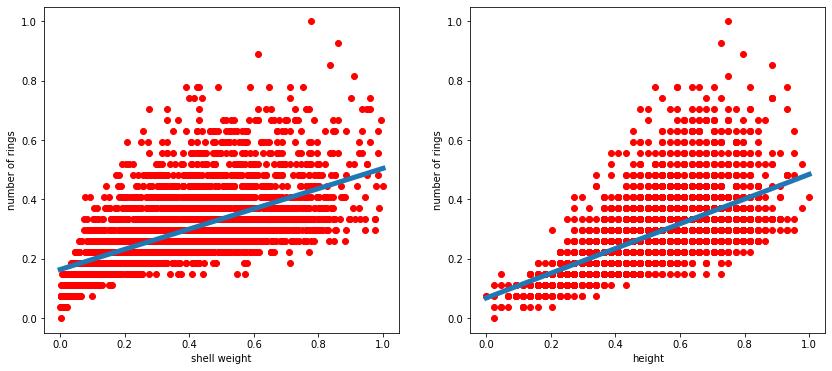

In [19]:
beta0_shellWeight, beta1_shellWeight = model_shellWeight.params
beta0_height, beta1_height = model_height.params

fig4, ax4 = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax4[0].plot(df_abalone_scaled.shell_weight, df_abalone_scaled.rings, 'ro');
xticks = np.linspace(0,1,10)
ax4[0].plot(xticks, beta0_shellWeight + beta1_shellWeight * xticks, lw=5)
ax4[0].set_xlabel('shell weight')
ax4[0].set_ylabel('number of rings');
ax4[1].plot(df_abalone_scaled.height, df_abalone_scaled.rings, 'ro');
# xticks = np.linspace(0,210,10)
ax4[1].plot(xticks, beta0_height + beta1_height * xticks, lw=5)
ax4[1].set_xlabel('height')
ax4[1].set_ylabel('number of rings');

The plots confirm the bad fit of the regression lines to the data.

#### Plotting the Residuals

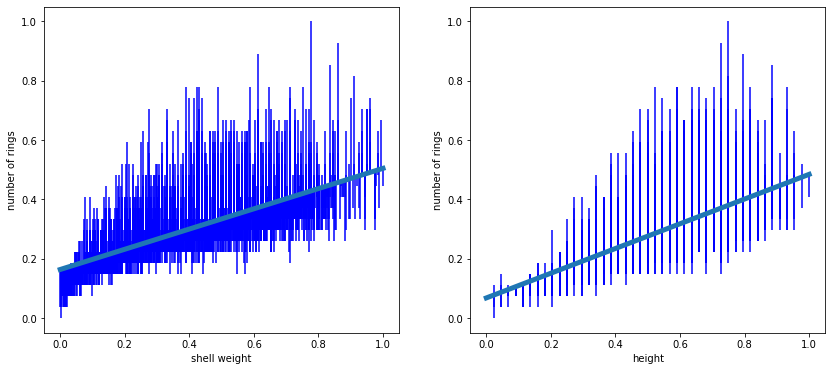

In [20]:
fig5, ax5 = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
yhat_shellWeight = beta0_shellWeight + beta1_shellWeight*df_abalone_scaled.shell_weight
yhat_height = beta0_height + beta1_height * df_abalone_scaled.height

ax5[0].vlines(df_abalone_scaled.shell_weight, ymin=yhat_shellWeight, ymax=df_abalone_scaled.rings, color='blue')
xticks = np.linspace(0,1,10)
ax5[0].plot(xticks, beta0_shellWeight + beta1_shellWeight * xticks, lw=5)
ax5[0].set_xlabel('shell weight')
ax5[0].set_ylabel('number of rings');

ax5[1].vlines(df_abalone_scaled.height, ymin=yhat_height, ymax=df_abalone_scaled.rings, color='blue')
ax5[1].plot(xticks, beta0_height + beta1_height * xticks, lw=5)
ax5[1].set_xlabel('height')
ax5[1].set_ylabel('number of rings');

The residuals are at some areas along the line very large. The RSS must be large.

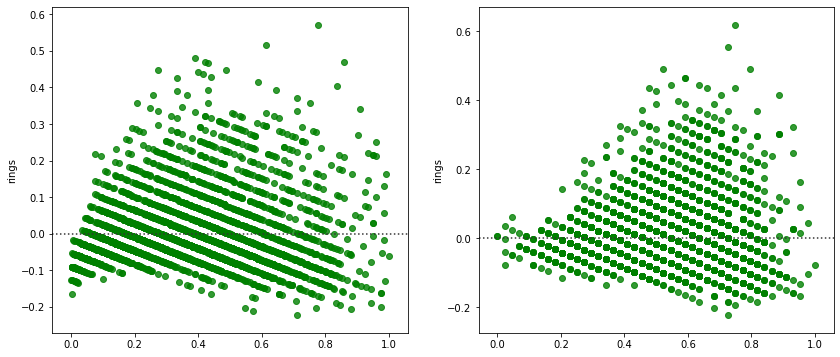

In [21]:
fig6, ax6 = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax6[0].set(ylabel = "")
ax6[1].set(ylabel = "")
sns.residplot(df_abalone_scaled.shell_weight.values, df_abalone_scaled.rings, color='g', ax=ax6[0])
sns.residplot(df_abalone_scaled.height.values, df_abalone_scaled.rings, color='g', ax=ax6[1]);

Furthermore, the residual plots show clearly a pattern and not random scatter.

In [22]:
#### Calculating the RSS

In [23]:
residuals_shellWeight = df_abalone_scaled.rings - yhat_shellWeight
RSS_shellWeight = np.sum(residuals_shellWeight ** 2)
residuals_height = df_abalone_scaled.rings - yhat_height
RSS_height = np.sum(residuals_height ** 2)
print('RSS for predictor shell_weight is ', RSS_shellWeight)
print('RSS for predictor height is ', RSS_height)

RSS for predictor shell_weight is  33.79953121649533
RSS for predictor height is  35.10911029232716


The RSS values seem to be relatively small. However, the data is scaled between 0 and 1, 
so that a value of greater than 33 is quite large.

#### Calculating a 95% Confidence Interval for each Model

In [24]:
print("Shell weight: beta0 = {}, beta1 = {}".format(beta0_shellWeight, beta1_shellWeight))
print(model_shellWeight.conf_int(0.05))
print("")
print("Height: beta0 = {}, beta1 = {}".format(beta0_height, beta1_height))
print(model_height.conf_int(0.05))

Shell weight: beta0 = 0.16350496545757578, beta1 = 0.3411618005559247
                     0         1
Intercept     0.157570  0.169440
shell_weight  0.327408  0.354915

Height: beta0 = 0.06762031154753212, beta1 = 0.4168357439863055
                  0         1
Intercept  0.057633  0.077608
height     0.399123  0.434548


The parameters beta0 and beta1 are for both predictors within the confidence interval. 
That means that the bad fit of the linear regression models is not caused by bad parameter estimates. 
Single linear regression is not the right model for this analysis.

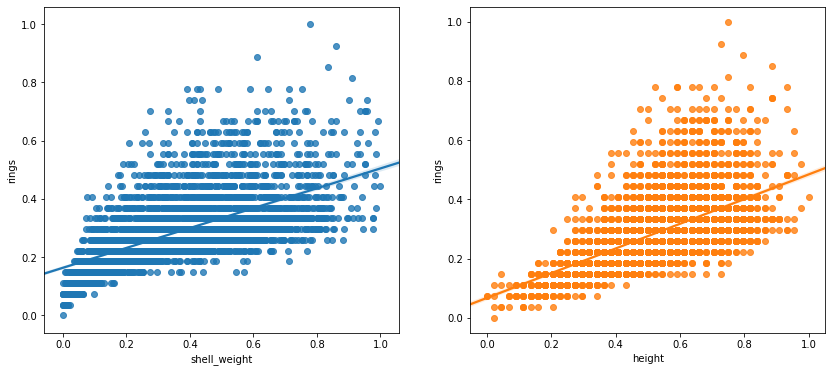

In [25]:
fig7, ax7 = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.regplot(x='shell_weight', y = 'rings', data=df_abalone_scaled, ci=95, ax=ax7[0])
sns.regplot(x='height', y = 'rings', data=df_abalone_scaled, ci=95, ax=ax7[1])